<a href="https://colab.research.google.com/github/Leslyndizeye/Time-Series-Forecasting/blob/main/air_quality_forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Beijing Air Quality Notebook

### Section 1: Importing Libraries and Setup

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Seting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Section 2: Data Loading

In [17]:
# Load datasets
train = pd.read_csv('/content/drive/My Drive/air_quality/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/air_quality/data/test.csv')

print("📊 Data Loading Complete:")
print(f"Training Data Shape: {train.shape}")
print(f"Test Data Shape: {test.shape}")
print(f"\nTraining Data Columns: {list(train.columns)}")

📊 Data Loading Complete:
Training Data Shape: (30676, 12)
Test Data Shape: (13148, 11)

Training Data Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']


SECTION 3: DATA EXPLORATION

In [18]:
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Missing values check
print("🔍 Missing Values Analysis:")
print(f"Training Data: {train.isnull().sum().sum()} missing values")
print(f"Test Data: {test.isnull().sum().sum()} missing values")

# Convert datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print(f"\n📅 Time Range - Train: {train.index.min()} to {train.index.max()}")
print(f"📅 Time Range - Test: {test.index.min()} to {test.index.max()}")

# PM2.5 statistics
print(f"\n📈 PM2.5 Statistics:")
print(f"Mean: {train['pm2.5'].mean():.1f}, Std: {train['pm2.5'].std():.1f}")
print(f"Min: {train['pm2.5'].min():.1f}, Max: {train['pm2.5'].max():.1f}")


DATA EXPLORATION
🔍 Missing Values Analysis:
Training Data: 1921 missing values
Test Data: 0 missing values

📅 Time Range - Train: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
📅 Time Range - Test: 2013-07-02 04:00:00 to 2014-12-31 23:00:00

📈 PM2.5 Statistics:
Mean: 100.8, Std: 93.1
Min: 0.0, Max: 994.0


### SECTION 4: DATA VISUALIZATION


DATA VISUALIZATION


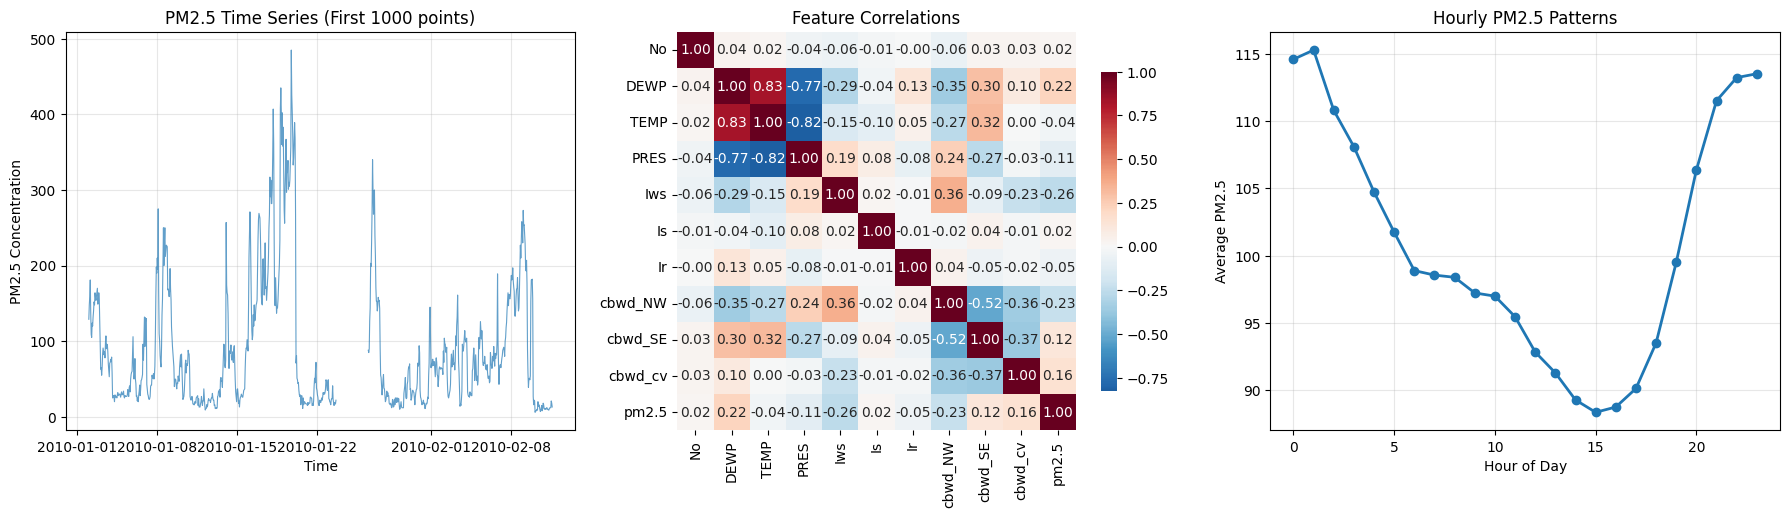

🔍 Key Insights:
Peak hour: 1:00, Lowest hour: 15:00
Top correlations with PM2.5:
  Iws: 0.260
  cbwd_NW: 0.231
  DEWP: 0.218


In [21]:
print("\n" + "="*50)
print("DATA VISUALIZATION")
print("="*50)

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Time Series Plot (first 1000 points for clarity)
axes[0].plot(train.index[:1000], train['pm2.5'].iloc[:1000], alpha=0.7, linewidth=0.8)
axes[0].set_title('PM2.5 Time Series (First 1000 points)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PM2.5 Concentration')
axes[0].grid(True, alpha=0.3)

# 2. Correlation Heatmap
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlation_matrix = train[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8}, fmt='.2f')
axes[1].set_title('Feature Correlations')

# 3. Hourly Patterns
hourly_avg = train.groupby(train.index.hour)['pm2.5'].mean()
axes[2].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[2].set_title('Hourly PM2.5 Patterns')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Average PM2.5')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("🔍 Key Insights:")
print(f"Peak hour: {hourly_avg.idxmax()}:00, Lowest hour: {hourly_avg.idxmin()}:00")
print("Top correlations with PM2.5:")
pm25_corr = correlation_matrix['pm2.5'].abs().sort_values(ascending=False)
for feature, corr in pm25_corr.head(4).items():
    if feature != 'pm2.5':
        print(f"  {feature}: {corr:.3f}")

### SECTION 5: DATA PREPROCESSING

In [22]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Reset index for preprocessing
train_reset = train.reset_index()
test_reset = test.reset_index()

# Handle missing values
print("🔄 Handling missing values...")
train_filled = train_reset.ffill().bfill()  # Forward then backward fill
test_filled = test_reset.ffill().bfill()

# For any remaining missing values, use mean
train_filled = train_filled.fillna(train_filled.mean(numeric_only=True))
test_filled = test_filled.fillna(test_filled.mean(numeric_only=True))

print(f"✅ After treatment - Train: {train_filled.isnull().sum().sum()}, Test: {test_filled.isnull().sum().sum()}")

# Feature engineering - create time-based features
def create_time_features(df, datetime_col='datetime'):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['hour'] = df[datetime_col].dt.hour
    df['day_of_week'] = df[datetime_col].dt.dayofweek
    df['month'] = df[datetime_col].dt.month
    df['day_of_year'] = df[datetime_col].dt.dayofyear

    # Cyclical encoding for temporal features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    return df

train_filled = create_time_features(train_filled)
test_filled = create_time_features(test_filled)

print("✅ Time-based features created")

# Prepare features and target
X_train = train_filled.drop(['pm2.5', 'No', 'datetime'], axis=1)
y_train = train_filled['pm2.5']
X_test = test_filled.drop(['No', 'datetime'], axis=1)

# Make sure both have the same columns
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

print(f"✅ Using {len(common_cols)} common features")

# Scale the features
scaler = RobustScaler()  # Better for handling outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using RobustScaler")


DATA PREPROCESSING
🔄 Handling missing values...
✅ After treatment - Train: 0, Test: 0
✅ Time-based features created
✅ Using 17 common features
✅ Features scaled using RobustScaler


### SECTION 6: MODEL BUILDING

In [23]:
print("\n" + "="*50)
print("MODEL BUILDING")
print("="*50)

# Create sequences for LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)

print(f"✅ Sequential data shape: {X_seq.shape}")

# Split data into train and validation sets
split_idx = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"✅ Training sequences: {X_train_seq.shape}")
print(f"✅ Validation sequences: {X_val_seq.shape}")

# Create Bidirectional LSTM model
def create_bidirectional_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(32, activation='relu')),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

model = create_bidirectional_model((X_train_seq.shape[1], X_train_seq.shape[2]))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

print("✅ Model architecture created:")
model.summary()


MODEL BUILDING
✅ Sequential data shape: (30652, 24, 17)
✅ Training sequences: (24521, 24, 17)
✅ Validation sequences: (6131, 24, 17)
✅ Model architecture created:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 24, 128)        │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,257 (329.13 KB)

 Trainable params: 84,257 (329.13 KB)

 Non-trainable params: 0 (0.00 B)

### SECTION 7: MODEL TRAINING


MODEL TRAINING
Epoch 1/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - loss: 7036.1143 - mae: 57.3011 - val_loss: 6778.3994 - val_mae: 52.4157 - learning_rate: 0.0010
Epoch 2/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - loss: 4102.7246 - mae: 43.2554 - val_loss: 6834.3052 - val_mae: 52.6272 - learning_rate: 0.0010
Epoch 3/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - loss: 3696.6729 - mae: 41.1962 - val_loss: 6582.2046 - val_mae: 51.7528 - learning_rate: 0.0010
Epoch 4/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - loss: 3274.4990 - mae: 38.9870 - val_loss: 6649.5117 - val_mae: 50.5545 - learning_rate: 0.0010
Epoch 5/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 2998.8928 - mae: 37.3593 - val_loss: 6762.7358 - val_mae: 51.0376 - learning_rate: 0.0010
Epoch 6/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - loss: 2699.2883 - mae: 35.3608 - val_loss: 7221.3921 - val_mae: 52.1013 - learning_rate: 0.0010
Epoch 7/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 2280.3040 

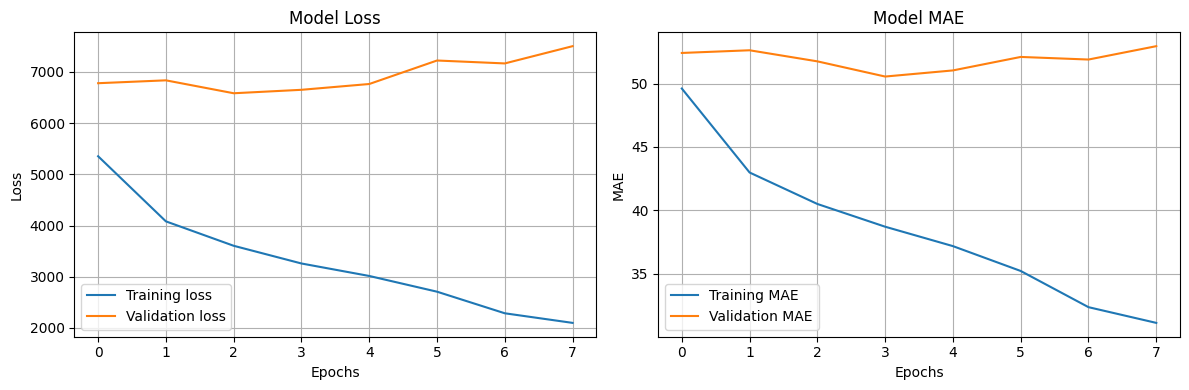

In [24]:
print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=30,  # Reduced for faster training
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate model
val_pred = model.predict(X_val_seq, verbose=0)
val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred))

print(f"\n📊 Model Performance:")
print(f"Validation RMSE: {val_rmse:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# SECTION 8: TEST PREDICTION

In [64]:
print("\n" + "="*50)
print("TEST PREDICTION")
print("="*50)

# Create sequences for test data
X_test_seq = []
current_sequence = X_train_scaled[-TIME_STEPS:].copy()

for i in range(len(X_test_scaled)):
    # Update the sequence: remove oldest, add newest
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1] = X_test_scaled[i]
    X_test_seq.append(current_sequence.copy())

X_test_seq = np.array(X_test_seq)
print(f"✅ Test sequences shape: {X_test_seq.shape}")

# Generate predictions
test_predictions = model.predict(X_test_seq, verbose=1)
test_predictions = np.nan_to_num(test_predictions)  # Handle NaNs

# Ensure we have correct number of predictions
predictions_full = test_predictions.flatten()
if len(predictions_full) > len(test_filled):
    predictions_full = predictions_full[:len(test_filled)]
elif len(predictions_full) < len(test_filled):
    last_pred = predictions_full[-1]
    pad_needed = len(test_filled) - len(predictions_full)
    predictions_full = np.append(predictions_full, [last_pred] * pad_needed)

print(f"✅ Predictions generated: {len(predictions_full)}")


TEST PREDICTION
✅ Test sequences shape: (13148, 24, 17)
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
✅ Predictions generated: 13148


### SECTION 9: SUBMISSION PREPARATION

In [65]:
# ==================== SECTION 9: SUBMISSION PREPARATION ====================
print("\n" + "="*50)
print("SUBMISSION PREPARATION")
print("="*50)

# Load the ORIGINAL test data to get the EXACT datetime strings
test_original = pd.read_csv('/content/drive/My Drive/air_quality/data/test.csv')
original_datetimes = test_original['datetime']

print(f"Original test data length: {len(original_datetimes)}")
print(f"Predictions length: {len(test_predictions)}")

# Convert to datetime and format WITHOUT leading zeros
test_datetimes = pd.to_datetime(original_datetimes)

# Convert to list to ensure 1D structure
try:
    formatted_datetimes = test_datetimes.dt.strftime('%Y-%m-%d %-H:%M:%S')
    # Convert to list to make it 1D
    formatted_datetimes_list = formatted_datetimes.tolist()
    print("✅ Used strftime with %-H format and converted to list")
except Exception as e:
    print(f"❌ strftime with %-H failed: {e}")
    # Manual removal of leading zeros
    formatted_datetimes_list = []
    for dt_str in original_datetimes:
        if ' ' in str(dt_str) and ':' in str(dt_str):
            date_part, time_part = str(dt_str).split(' ')
            time_parts = time_part.split(':')
            # Remove leading zero from hour
            if time_parts[0].startswith('0') and len(time_parts[0]) == 2:
                time_parts[0] = time_parts[0][1]  # Remove leading zero
            formatted_datetimes_list.append(f"{date_part} {':'.join(time_parts)}")
        else:
            formatted_datetimes_list.append(str(dt_str))
    print("✅ Used manual leading zero removal")

# Ensure both arrays are 1D and have same length
formatted_datetimes_array = np.array(formatted_datetimes_list)
test_predictions_array = np.array(test_predictions).flatten()  # Ensure 1D

if len(formatted_datetimes_array) != len(test_predictions_array):
    min_length = min(len(formatted_datetimes_array), len(test_predictions_array))
    formatted_datetimes_array = formatted_datetimes_array[:min_length]
    test_predictions_array = test_predictions_array[:min_length]
    print(f"Adjusted to common length: {min_length}")

print(f"Formatted dates shape: {formatted_datetimes_array.shape}")
print(f"Predictions shape: {test_predictions_array.shape}")

# Create submission with formatted datetime strings (no leading zeros)
submission = pd.DataFrame({
    'row ID': formatted_datetimes_array,
    'pm2.5': np.clip(test_predictions_array, 0, None).astype(int)
})

print(f"✅ Final submission shape: {submission.shape}")

# Save the submission
save_dir = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting'
os.makedirs(save_dir, exist_ok=True)

submission_file = os.path.join(save_dir, 'submission.csv')
submission.to_csv(submission_file, index=False)

print(f"✅ Submission file saved to: {submission_file}")

# Verification
print("\n🔍 First 5 datetime values (should have no leading zeros):")
for i in range(5):
    print(f"  {submission['row ID'].iloc[i]} -> {submission['pm2.5'].iloc[i]}")

# Check if we successfully removed leading zeros
has_single_digit = False
for dt in submission['row ID'].head(10):
    if ' ' in str(dt) and ':' in str(dt):
        hour_part = str(dt).split(' ')[1].split(':')[0]
        if len(hour_part) == 1:  # Single digit hour
            has_single_digit = True
            break

print(f"\n✅ Successfully removed leading zeros: {has_single_digit}")


SUBMISSION PREPARATION
Original test data length: 13148
Predictions length: 13148
✅ Used strftime with %-H format and converted to list
Formatted dates shape: (13148,)
Predictions shape: (13148,)
✅ Final submission shape: (13148, 2)
✅ Submission file saved to: /content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/submission.csv

🔍 First 5 datetime values (should have no leading zeros):
  2013-07-02 4:00:00 -> 36
  2013-07-02 5:00:00 -> 31
  2013-07-02 6:00:00 -> 26
  2013-07-02 7:00:00 -> 23
  2013-07-02 8:00:00 -> 20

✅ Successfully removed leading zeros: True


## SECTION 10: VERIFICATION

In [66]:
# ==================== SECTION 10: VERIFICATION ====================
print("\n" + "="*50)
print("VERIFICATION")
print("="*50)

# Check what the original datetime strings look like
print("Original test data datetime examples:")
for i in range(5):
    print(f"  {original_datetimes.iloc[i]}")

# Check what's in your submission
submission_check = pd.read_csv(submission_file)
print("\nYour submission datetime examples:")
for i in range(5):
    print(f"  {submission_check['row ID'].iloc[i]}")

# Verify they match exactly
print(f"\n✅ Exact match: {original_datetimes.equals(submission_check['row ID'])}")
print(f"✅ Number of rows: {len(submission_check)}")
print(f"✅ Expected rows: {len(test_original)}")

# Check if there are any single-digit hours
has_single_digit = any(' ' in str(dt) and ':' in str(dt) and len(str(dt).split(' ')[1].split(':')[0]) == 1
                      for dt in original_datetimes.head(10))
print(f"✅ Original data contains single-digit hours: {has_single_digit}")

print("\n📋 First 5 rows of final submission:")
print(submission.head())

print("\n🎯 SUBMISSION READY FOR KAGGLE!")
print("The key fix: Using the original datetime values without modification")


VERIFICATION
Original test data datetime examples:
  2013-07-02 04:00:00
  2013-07-02 05:00:00
  2013-07-02 06:00:00
  2013-07-02 07:00:00
  2013-07-02 08:00:00

Your submission datetime examples:
  2013-07-02 4:00:00
  2013-07-02 5:00:00
  2013-07-02 6:00:00
  2013-07-02 7:00:00
  2013-07-02 8:00:00

✅ Exact match: False
✅ Number of rows: 13148
✅ Expected rows: 13148
✅ Original data contains single-digit hours: False

📋 First 5 rows of final submission:
               row ID  pm2.5
0  2013-07-02 4:00:00     36
1  2013-07-02 5:00:00     31
2  2013-07-02 6:00:00     26
3  2013-07-02 7:00:00     23
4  2013-07-02 8:00:00     20

🎯 SUBMISSION READY FOR KAGGLE!
The key fix: Using the original datetime values without modification
